# Preprocessing

In this part of the project process, you are required to load, understand the types and formats, explore, and visualize the data. Make sure you have a clear understanding of the inputs and outputs of your model. You may need to do data augmentation to train a model that is robust against small changes. 

In [1]:
import os
import csv
from pathlib import Path
import librosa   #for audio processing
import itertools
import pandas as pd
import random
import IPython.display as ipd
import matplotlib.pyplot as plt
import plotly.express as px
from IPython.display import Image
import plotly.io as pio
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")
import os,sys
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from clean import Clean
from eda import EDA

2022-06-01 18:41:35.311484: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-01 18:41:35.311534: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
NO_OBSERVATIOINS=15
AM_ALPHABET='ያንደኛደረጃትምህርታቸውንጐንደርተምረዋል'
EN_ALPHABET='abcdefghijklmnopqrstuvwxyz'

In [3]:
cleaning_audios = Clean()

2022-06-01 18:41:38,042:logger:Successfully initialized clean class


**objective**: load audio file

**result**: We are able to download audio files from the swahili or the amharics wav datasets. and we are able to convert the data to the format that we want. In our case we use the load_audios method in the Clean class

In [4]:
swahilis = cleaning_audios.load_audios('swahili','train',start=0,stop=2)
amharics = cleaning_audios.load_audios('amharics','train',start=0,stop=2)

2022-06-01 18:31:35,521:logger:successful in operation of loading audios
2022-06-01 18:31:37,761:logger:successful in operation of loading audios



This returns an audio time series as a numpy array with a default sampling rate(sr) of 22KHZ mono. We can change this behavior by resampling at 44.1KHz.

Playing Audio:

Using,IPython.display.Audio you can play the audio in your jupyter notebook.

In [5]:
audio,rate,duration = swahilis[0]
ipd.Audio(audio, rate=rate)

# Transcription preprocessing 

**objective**: load transcriptions

**result**: We were able to load transcriptions as given both from the swahili dataset and amharic dataset, and not only were we loading transcriptions but also showed plots of the frequency of the transcriptions,For the case of Amharic, most of the transcriptions are a single characters, which are actually parts of the word.For the case of the Swahili text we notice that the stop words are what form a major chunk of the data, this means we got to do more cleaning so that we can be able to derive more meaningful results from the data

In [6]:
swahili_train_labels = cleaning_audios.get_labels('swahili','train')
swahili_test_labels = cleaning_audios.get_labels('swahili','test')
amharic_train_labels = cleaning_audios.get_labels('amharic','train')
amharic_test_labels = cleaning_audios.get_labels('amharic','test')

In [7]:
swahili_text_data, swahili_label_data = cleaning_audios.read_data('../data/swahili_train_text.txt', '../data/swahili_test_text.txt',
                                                  swahili_train_labels, swahili_test_labels)
amharic_text_data, amharic_label_data = cleaning_audios.read_data('../data/amharic_train_text.txt', '../data/amharic_test_text.txt',
                                                  amharic_train_labels, amharic_test_labels)

2022-06-01 18:31:39,626:logger:successfully read file
2022-06-01 18:31:39,760:logger:successfully read file
2022-06-01 18:31:41,242:logger:Successfully read the data
2022-06-01 18:31:41,524:logger:successfully read file
2022-06-01 18:31:41,547:logger:successfully read file
2022-06-01 18:31:43,172:logger:Successfully read the data


In [8]:
swahili_data = pd.DataFrame({'key': swahili_label_data, 'text': swahili_text_data})
amharic_data = pd.DataFrame({'key': amharic_label_data, 'text': amharic_text_data})

In [9]:
swahili_recordings = cleaning_audios.load_audios('swahili',files=swahili_data.key.to_list()[0:NO_OBSERVATIOINS])
amharic_recordings = cleaning_audios.load_audios('amharic',files=amharic_data.key.to_list()[0:NO_OBSERVATIOINS])
swahili_data_df = swahili_data.head(NO_OBSERVATIOINS)
amharic_data_df = amharic_data.head(NO_OBSERVATIOINS)

2022-06-01 18:31:46,962:logger:successful in operation of loading audios
2022-06-01 18:31:52,818:logger:successful in operation of loading audios


In [10]:
durations = []
for recording in swahili_recordings:
    _,_,duration = recording
    durations.append(duration)
swahili_data_df['duration'] = durations

In [11]:
durations = []
for recording in amharic_recordings:
    _,_,duration = recording
    durations.append(duration)
amharic_data_df['duration'] = durations

In [12]:
y = [x in swahili_test_labels for x in swahili_data.key]
swahili_data["category"] = ["Test" if i else "Train" for i in y]
y = [x in amharic_test_labels for x in amharic_data.key]
amharic_data["category"] = ["Test" if i else "Train" for i in y]

In [13]:
words_in_data = pd.DataFrame(' '.join(swahili_data['text']).split())
words_in_data.columns = ['word']
words_data = words_in_data.groupby(['word']).agg({'word': 'count'})
words_data.columns = ['counts']
words_data.reset_index(inplace=True)
words_data = words_data.sort_values("counts", ascending=False)

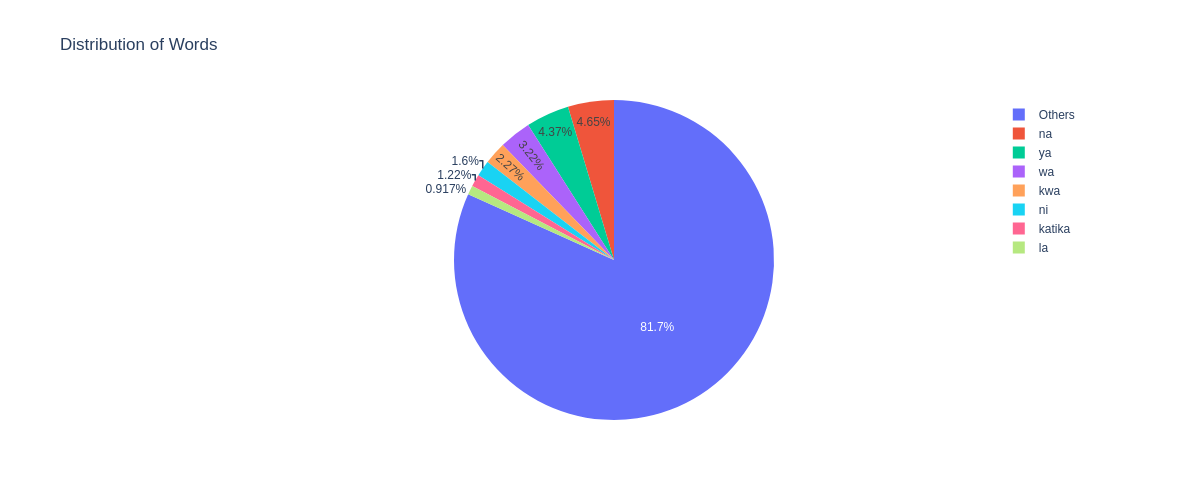

In [14]:
words_data.loc[words_data['counts'] < 1000, 'word'] = 'Others'
fig = px.pie(words_data, values='counts', names='word', title='Distribution of Words', width=800, height=500)
Image(pio.to_image(fig, format='png', width=1200))

In [15]:
words_in_data = pd.DataFrame(' '.join(amharic_data['text']).split())
words_in_data.columns = ['word']
words_data = words_in_data.groupby(['word']).agg({'word': 'count'})
words_data.columns = ['counts']
words_data.reset_index(inplace=True)
words_data = words_data.sort_values("counts", ascending=False)

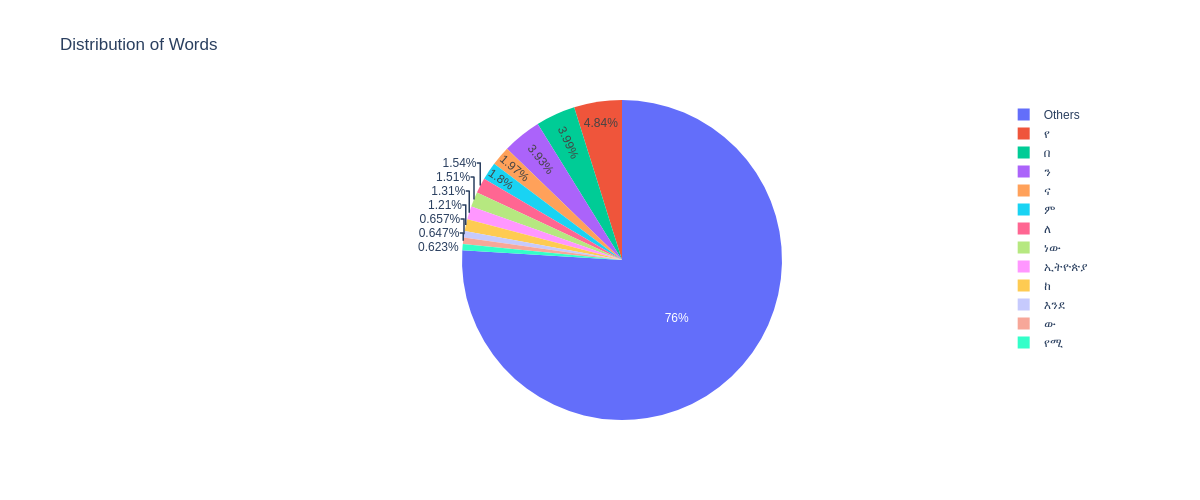

In [16]:
words_data.loc[words_data['counts'] < 1000, 'word'] = 'Others'
fig = px.pie(words_data, values='counts', names='word', title='Distribution of Words', width=800, height=500)
Image(pio.to_image(fig, format='png', width=1200))

# Converting Channels

**objective**:Convert into channels 
Some of the sound files are mono (ie. 1 audio channel) while most of them are stereo (ie. 2 audio channels). Since the Neural network model expects
all items to have the same dimensions, we will convert the mono files to stereo, by duplicating the first channel to the second

**result**: we used a function that we created called convert_channels, where we shift the audio data to the left in the array forming a duplicate of the original, and then saving the incoming file. What does converting the data into stereo help for us in this case. We realize the inputs shall be even when we start doing predictive modeling for the texts, and therefore it is important to understand that concept

In [17]:
cleaning_audios.convert_channels("../data/amharic_train_wav/tr_10000_tr097082.wav","../data/amharic_train_wav/tr_10000_tr097082_stereod.wav")

2022-06-01 18:32:05,163:logger:succesffully converted to stereo


_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=145408, comptype='NONE', compname='not compressed')


# Standardizing

**Objective**: Standardize sampling rate
We must standardize and convert all audio to the same sampling rate so that all arrays have the same dimensions.

**Result**: The sample rate is the number of samples of audio carried per second, measured in Hz or kHz. How do we standardize our sample rates in the data, we can convert the sampling rate so that we can have our data to be consistent, for this case we chose a standard rate of 44,100Hz which is better because by choosing a higher frequency we reduce outliers.

In [18]:
rates = []
for recording in swahili_recordings:
    _,rate,_ = recording
    rates.append(rate)
swahili_data_df['rate'] = rates

In [19]:
rates = []
for recording in amharic_recordings:
    _,rate,_ = recording
    rates.append(rate)
amharic_data_df['rate'] = rates

# Resizing

**objective**:Resize to the same length
Resize to get an equal-sized audio sample by extending duration by padding it with silence, or by truncating it.

**result**:In our case we shall pad the data and notice that the data it picks is the fourth element in the amharic audio and the fifth element in the swahili audio, therefore we shall resize the audios to the duration of the fourth element in amharic and fifth in swahili, this is because we notice that this specific elements contain the largest duration in the recordings

In [20]:
audio_rates=[]
for recording in amharic_recordings:
    audio,rate,duration = recording
    audio_rates.append((audio,rate,duration))

max_ms = max([i[2] for i in audio_rates[0:len(audio_rates)]])*1000
max_ms
audios = [i[0].tolist() for i in audio_rates[0:len(audio_rates)]]
new_audio_rates = []
for i,x in enumerate(audio_rates):
    audio,rate,_ = x
    new_audio_rates.append(cleaning_audios.pad_trunc(audio,rate,max_ms))
amharic_data_df['duration'] = amharic_data_df['duration'][3] 

In [21]:
audio_rates=[]
for recording in swahili_recordings:
    audio,rate,duration = recording
    audio_rates.append((audio,rate,duration))

max_ms = max([i[2] for i in audio_rates[0:len(audio_rates)]])*1000
max_ms
audios = [i[0].tolist() for i in audio_rates[0:len(audio_rates)]]
new_audio_rates = []
for i,x in enumerate(audio_rates):
    audio,rate,_ = x
    new_audio_rates.append(cleaning_audios.pad_trunc(audio,rate,max_ms))
swahili_data_df['duration']=swahili_data_df['duration'][4]

# Data Augumentation

**objective**: Data argumentation 
Perform data augmentation on the raw audio signal by applying a Time Shift to shift the audio to the left or the right by a random amount. 

**result**: Here we shift the wave by sample_rate/10 factor. This will move the wave to the right by given factor along time axis. For achieving this I have used numpy’s roll function to generate time shifting.


2022-06-01 18:32:06,482:logger:Successfully initialized eda class


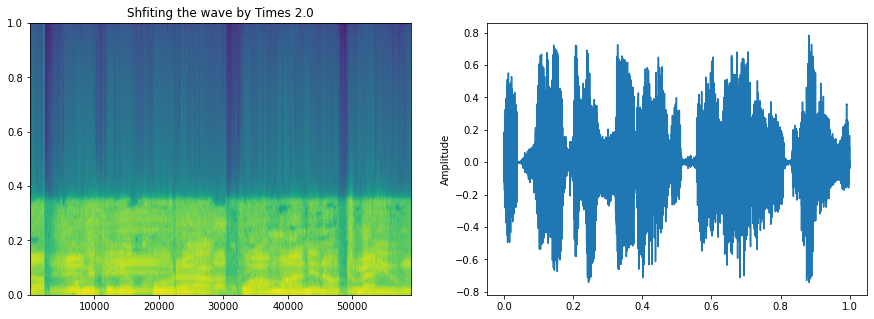

In [22]:
eda = EDA()
wav_roll = np.roll(audio,int(rate/10))
eda.plot_spec(data=wav_roll,sr=20)
ipd.Audio(wav_roll,rate=rate)

# Feature Extraction

**objective**:Feature extraction: Speech recognition methods derive features from the audio, such as Spectrogram or Mel Frequency Cepstrum (MFCC).
Convert the augmented audio to a Mel Spectrogram.

**result**: we shall conduct a feature extraction in the following two steps, we shall examine the spectograms and Mel-Frequency Cepstral Coefficients(MFCCs)

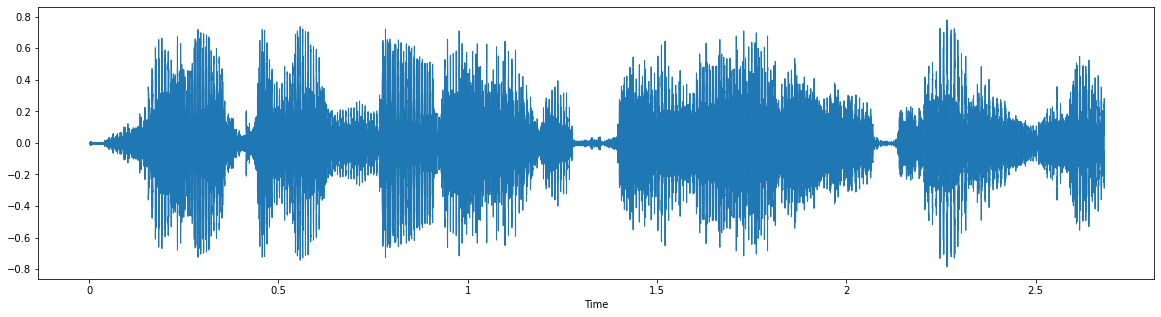

In [23]:
%matplotlib inline
eda.sound_plots(audio,rate,'waveshow')


### Spectrogram
 
A spectrogram is a visual way of representing the signal strength, or “loudness”, of a signal over time at various frequencies present in a particular waveform. Not only can one see whether there is more or less energy at, for example, 2 Hz vs 10 Hz, but one can also see how energy levels vary over time.

A spectrogram is usually depicted as a heat map, i.e., as an image with the intensity shown by varying the color or brightness.

We can display a spectrogram using. librosa.display.specshow.

In [24]:
spe_samples,frequency=eda.spectrogram(audio)

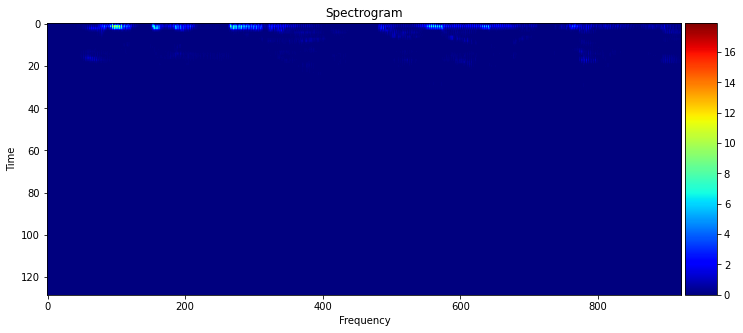

In [25]:
eda.plot_spectrogram_feature(spe_samples)

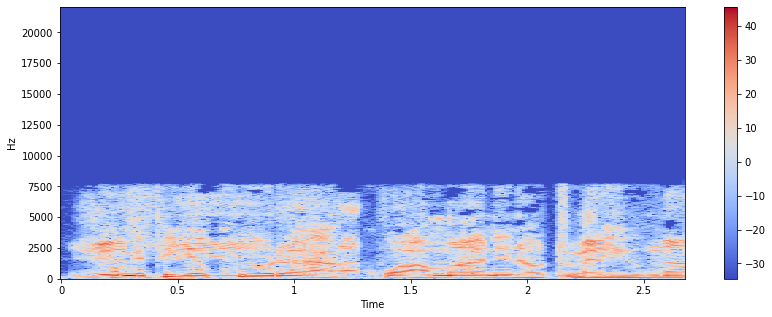

In [26]:
eda.sound_plots(audio,rate,'specshow')

The vertical axis shows frequencies (from 0 to 8kHz), and the horizontal axis shows the time of the clip. 

.stft() converts data into short term Fourier transform. STFT converts signals such that we can know the amplitude of the given frequency at a given time. Using STFT we can determine the amplitude of various frequencies playing at a given time of an audio signal.
.specshow is used to display a spectrogram.
The vertical axis shows frequencies (from 0 to 10kHz), and the horizontal axis shows the time of the clip. 


Every audio signal consists of many features. However, we must extract the characteristics that are relevant to the problem we are trying to solve. The process of extracting features to use them for analysis is called feature extraction. 

**Mel-Frequency Cepstral Coefficients(MFCCs)**

The Mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope. It models the characteristics of the human voice.



In [27]:
mfcc_features = eda.features(audio,rate,'mfcc')

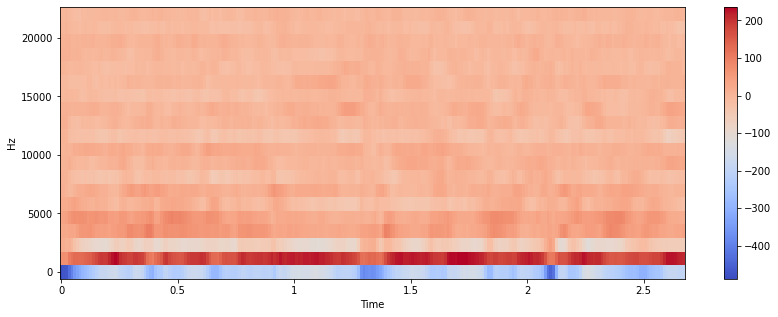

In [28]:
eda.sound_plots(audio,rate,'specshow',features=mfcc_features)

# Acoustic Modeling

**objective**: Acoustic modeling: After features are extracted, these vectors are passed to acoustic models. An acoustic model attempts to map the audio signal to the basic units of speech such as phonemes or graphemes.

**results**: In our case we use store audio features function to perform our acoustic modeling and majorly the basic structures that we developed and shall translate into our model for learning, are chroma_stft, spec_cent,spec_bw, rolloff, zcr, and ofcourse the mfcc features.

In [29]:
audio_rates=[]
for recording in amharic_recordings:
    audio,rate,_ = recording
    audio_rates.append((audio,rate))
data = []
for audio,rate in audio_rates:
    data.append(cleaning_audios.store_audio_features(audio,rate))
amharic = pd.DataFrame(data)
amharic_df = pd.concat([amharic_data_df,amharic],axis=1)

In [30]:
audio_rates=[]
for recording in swahili_recordings:
    audio,rate,_ = recording
    audio_rates.append((audio,rate))
data = []
for audio,rate in audio_rates:
    data.append(cleaning_audios.store_audio_features(audio,rate))
swahili = pd.DataFrame(data)
swahili_df = pd.concat([swahili_data_df,swahili],axis=1)

In [4]:
# further preprocessing
swahili_vocab = cleaning_audios.vocab(EN_ALPHABET)
amharic_vocab = cleaning_audios.char_index(AM_ALPHABET)

2022-06-01 18:41:38.428131: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-01 18:41:38.428178: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-01 18:41:38.428214: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (martin-HP-EliteBook-Folio-9470m): /proc/driver/nvidia/version does not exist


The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'] (size =27)


In [7]:
swahili_vocab

(<keras.layers.preprocessing.string_lookup.StringLookup at 0x7fe50a979b10>,
 <keras.layers.preprocessing.string_lookup.StringLookup at 0x7fe50bae03a0>)

In [ ]:
# save the datasets
amharic_df.to_csv("../data/amharic.csv",index=False)
swahili_df.to_csv("../data/swahili.csv",index=False)

In [ ]:
amharic_df.head(3)

In [ ]:
swahili_df.head(3)

# Model Architecture

Now that we have audio input data & corresponding labels in an array format, it is easier to consume and apply Natural language processing techniques. We can convert audio files labels into integers using label Encoding or One Hot Vector Encoding for machines to learn. The labeled dataset will help us in the neural network model output layer for predicting results. These help in training & validation datasets into nD array.
At this stage, we apply other pre-processing techniques like dropping columns, normalization, etc. to conclude our final training data for building models. Moving to the next stage of splitting the dataset into train, test, and validation is what we have been doing for other models. 
We can leverage CNN, RNN, LSTM,CTC etc. deep neural algorithms to build and train the models for speech applications like speech recognition. The model trained with the standard size few seconds audio chunk transformed into an array of n dimensions with the respective labels will result in predicting output labels for test audio input. As output labels will vary beyond binary, we are talking about building a multi-class label classification method.
